In [1]:
from pyspark import SparkContext
import pyspark

In [2]:
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

In [17]:
from numpy import array
from math import sqrt
from numpy import genfromtxt
import pandas as pd
from pyspark.mllib.clustering import KMeans

sqlContext = SQLContext(sc)

#Load and parse the data
dataset = sqlContext.read.format('com.databricks.spark.csv').options(header='true').load('/home/munindra/Desktop/Final_Yr_Proj/diabetes.csv')
df = pd.read_csv('/home/munindra/Desktop/Final_Yr_Proj/diabetes.csv',delimiter=',') # path to file here

label = df.as_matrix(columns=df.columns[9:])
label = label.ravel()
dataset = dataset.na.drop()

dataset.show()

+---+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
| id|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+---+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|  0|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|  1|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|  2|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|  3|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|  4|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
|  5|          5|    116|           74|            0|      0|25.6|                   0.201| 30|      0|
|  6|          3|     78|           50|           32|     88|  3

In [25]:
dft = dataset.select(*(dataset[c].cast("float").alias(c) for c in dataset.columns[1:]))

from pyspark.sql.functions import monotonically_increasing_id 

dft = dft.select("*").withColumn("id", monotonically_increasing_id())

#split outcome
label = dft[["Outcome"]]
dft = dft.drop('Outcome')
dft.head()

Row(Pregnancies=6.0, Glucose=148.0, BloodPressure=72.0, SkinThickness=35.0, Insulin=0.0, BMI=33.599998474121094, DiabetesPedigreeFunction=0.6269999742507935, Age=50.0, id=0)

In [26]:
from pyspark.ml.feature import VectorAssembler # in spark api we have to convert data to vectors in order to run the model.
# kmeans is imported from pyspark.ml.clustering
from pyspark.ml.clustering import KMeans

# creating an instance of the vector assembler 
assembler = VectorAssembler(inputCols = dft.columns, outputCol = 'features')

# transforming dataframe into vector assembler 
final_df = assembler.transform(dft)
final_df.drop('Outcome')

final_df.show(5)

+-----------+-------+-------------+-------------+-------+----+------------------------+----+---+--------------------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction| Age| id|            features|
+-----------+-------+-------------+-------------+-------+----+------------------------+----+---+--------------------+
|        6.0|  148.0|         72.0|         35.0|    0.0|33.6|                   0.627|50.0|  0|[6.0,148.0,72.0,3...|
|        1.0|   85.0|         66.0|         29.0|    0.0|26.6|                   0.351|31.0|  1|[1.0,85.0,66.0,29...|
|        8.0|  183.0|         64.0|          0.0|    0.0|23.3|                   0.672|32.0|  2|[8.0,183.0,64.0,0...|
|        1.0|   89.0|         66.0|         23.0|   94.0|28.1|                   0.167|21.0|  3|[1.0,89.0,66.0,23...|
|        0.0|  137.0|         40.0|         35.0|  168.0|43.1|                   2.288|33.0|  4|[0.0,137.0,40.0,3...|
+-----------+-------+-------------+-------------+-------

In [27]:
# in clustering we have to scale the features so as to reduce the distance and which helps in computation become faster
from pyspark.ml.feature import StandardScaler

# created instance of the standard scaler
scaler = StandardScaler(inputCol = 'features', outputCol = 'scaledFeatures')

#fitting the vector data and transforming with scaler transformation
scaler_model = scaler.fit(final_df)
final_df = scaler_model.transform(final_df)
final_df.show(6)

+-----------+-------+-------------+-------------+-------+----+------------------------+----+---+--------------------+--------------------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction| Age| id|            features|      scaledFeatures|
+-----------+-------+-------------+-------------+-------+----+------------------------+----+---+--------------------+--------------------+
|        6.0|  148.0|         72.0|         35.0|    0.0|33.6|                   0.627|50.0|  0|[6.0,148.0,72.0,3...|[1.78063837321943...|
|        1.0|   85.0|         66.0|         29.0|    0.0|26.6|                   0.351|31.0|  1|[1.0,85.0,66.0,29...|[0.29677306220323...|
|        8.0|  183.0|         64.0|          0.0|    0.0|23.3|                   0.672|32.0|  2|[8.0,183.0,64.0,0...|[2.37418449762590...|
|        1.0|   89.0|         66.0|         23.0|   94.0|28.1|                   0.167|21.0|  3|[1.0,89.0,66.0,23...|[0.29677306220323...|
|        0.0|  137.0|      

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from time import time


cost = np.zeros(20)
for k in range(2,20):
    start = time()
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(final_df.sample(False,0.1, seed=42))
    cost[k] = model.computeCost(final_df)
    end = time()
    print ("K means from spark took {:.4f} seconds(k = {:.4f})".format(end - start,k))


K means from spark took 1.5304 seconds(k = 2.0000)
K means from spark took 0.8338 seconds(k = 3.0000)
K means from spark took 0.9199 seconds(k = 4.0000)
K means from spark took 0.8871 seconds(k = 5.0000)
K means from spark took 1.1238 seconds(k = 6.0000)
K means from spark took 1.0188 seconds(k = 7.0000)
K means from spark took 1.0170 seconds(k = 8.0000)
K means from spark took 1.2007 seconds(k = 9.0000)
K means from spark took 0.9211 seconds(k = 10.0000)
K means from spark took 0.8699 seconds(k = 11.0000)
K means from spark took 0.8554 seconds(k = 12.0000)
K means from spark took 0.7545 seconds(k = 13.0000)
K means from spark took 0.9087 seconds(k = 14.0000)
K means from spark took 0.7456 seconds(k = 15.0000)
K means from spark took 0.9160 seconds(k = 16.0000)
K means from spark took 0.7639 seconds(k = 17.0000)
K means from spark took 0.8483 seconds(k = 18.0000)
K means from spark took 0.9783 seconds(k = 19.0000)


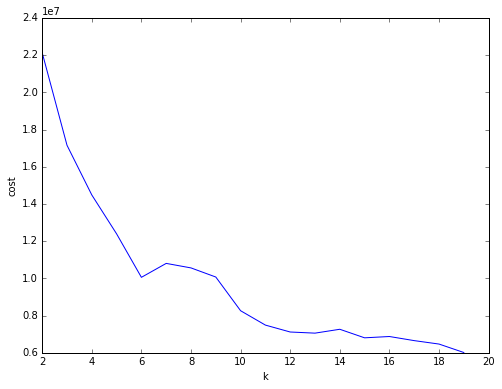

In [8]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [39]:
best_k = 15 # choose best k from elbow curve
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(final_df)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[  2.91666667 138.25        72.83333333  33.70833333 220.875
  37.02916678   0.597625    32.16666667 407.16666667]
[  4.54166667 111.38888889  66.54166667  13.          10.23611111
  29.44722226   0.44433334  32.83333333  55.61111111]
[2.76315789e+00 1.21105263e+02 6.83157895e+01 2.61842105e+01
 1.32184211e+02 3.16631580e+01 4.67421054e-01 2.93684211e+01
 5.97263158e+02]
[  4.04081633 137.83673469  65.20408163   9.87755102   0.
  32.47142854   0.43987755  36.40816327 260.18367347]
[  4.28571429 132.82857143  70.68571429  27.4        169.25714286
  33.32285712   0.60431428  33.22857143 292.54285714]
[  2.88888889 158.77777778  75.55555556  36.11111111 553.55555556
  37.47777854   0.89822223  28.55555556 379.66666667]
[4.43478261e+00 1.20108696e+02 7.11521739e+01 1.52173913e+01
 5.39130435e+00 3.22000000e+01 4.07521740e-01 3.63043478e+01
 7.31086957e+02]
[3.84615385e+00 1.27358974e+02 7.44615385e+01 3.19743590e+01
 1.54692308e+02 3.52589741e+01 5.19051286e-01 3.24871795

In [40]:
predicts = model.transform(final_df)

In [1]:
#predicts.show(40)
#df.select("prediction").collect()